# MSE with time dependent transcription rate

## Library imports

In [1]:
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from velovi import preprocess_data, VELOVI

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True

## Function definitions

In [5]:
def fit_velovi(bdata, time_dep_transcription_rate=False):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata, time_dep_transcription_rate=time_dep_transcription_rate)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    if vae.module.time_dep_transcription_rate:
        bdata.var["fit_alpha_1"] = vae.get_rates()["alpha_1"] / scaling
        bdata.var["fit_lambda_alpha"] = vae.get_rates()["lambda_alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [6]:
def get_fit_velovi(bdata, model):
    return model.get_expression_fit(n_samples=20)

In [7]:
def compute_mse(ms, mu, time_dep_velovi_fit_s, time_dep_velovi_fit_u, const_velovi_fit_s, const_velovi_fit_u):
    time_dep_velovi_mse_s = np.mean((time_dep_velovi_fit_s - ms) ** 2, axis=0)
    time_dep_velovi_mse_u = np.mean((time_dep_velovi_fit_u - mu) ** 2, axis=0)
    const_velovi_mse_s = np.mean((const_velovi_fit_s - ms) ** 2, axis=0)
    const_velovi_mse_u = np.mean((const_velovi_fit_u - mu) ** 2, axis=0)

    mse_df = pd.DataFrame()
    s = np.log10(const_velovi_mse_s / time_dep_velovi_mse_s)
    u = np.log10(const_velovi_mse_u / time_dep_velovi_mse_u)

    mse_df["log10 MSE ratio"] = np.concatenate([s, u]).ravel()
    mse_df["Feature"] = ["Spliced"] * len(s) + ["Unspliced"] * len(u)
    return mse_df

## Data loading

In [8]:
adatas = [
    scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad"),
    scv.datasets.dentategyrus_lamanno(DATA_DIR / "dentategyrus" / "DentateGyrus.loom"),
    scv.datasets.forebrain(DATA_DIR / "ForebrainGlut" / "hgForebrainGlut.loom"),
    sc.read(DATA_DIR / 'retina' / 'mouse_retina.h5ad'),
]

names = ["Pancreas", "Dentategyrus", "Forebrain", 'Retina']

  0%|          | 0.00/29.2M [00:00<?, ?B/s]

## Data preprocessing

In [9]:
for adata_id, adata in enumerate(adatas):
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    adatas[adata_id] = preprocess_data(adata)
    
bdatas = [a.copy() for a in adatas]

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.

## Model training

### Constant transcription rate

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:53<00:00,  2.26it/s, loss=-2.65e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:53<00:00,  2.14it/s, loss=-2.65e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 236/500:  47%|██████████████████████████████████████████████▋                                                    | 236/500 [09:15<10:21,  2.35s/it, loss=-4.63e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -4516.801. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 428/500:  86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 428/500 [01:48<00:18,  3.93it/s, loss=-1.4e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1375.804. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 445/500:  89%|█████████████████████████████████████████████████████████████████████████████████████████           | 445/500 [03:18<00:24,  2.24it/s, loss=-1.9e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1827.274. Signaling Trainer to stop.


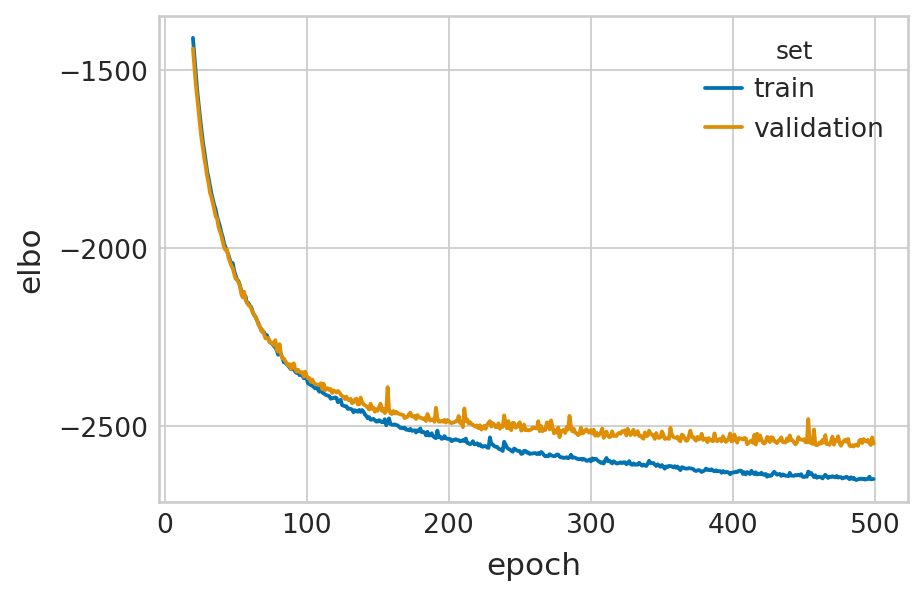

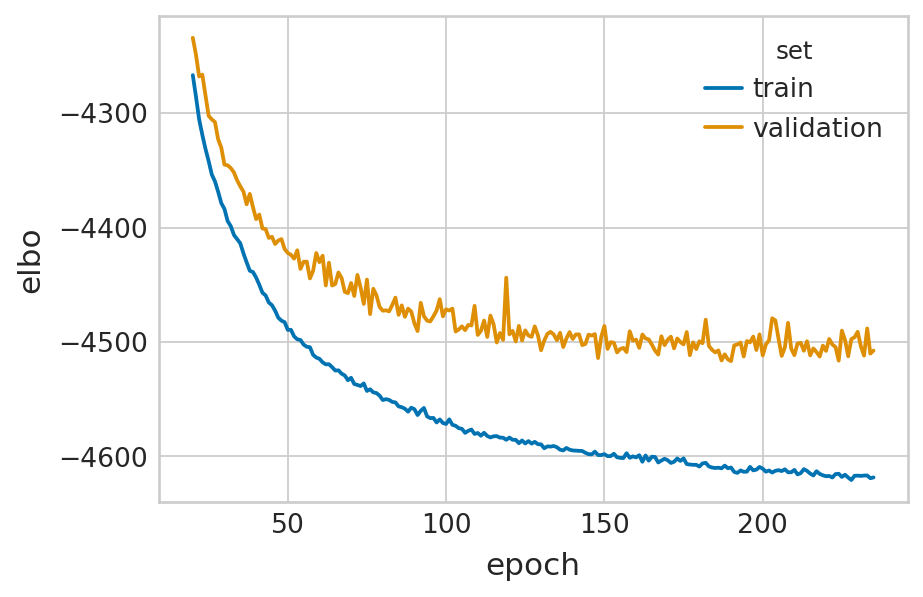

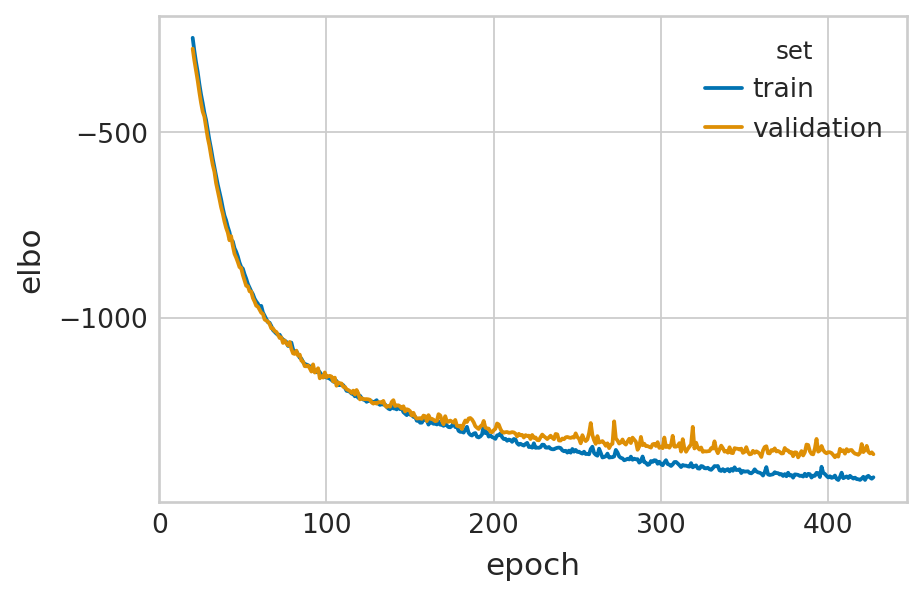

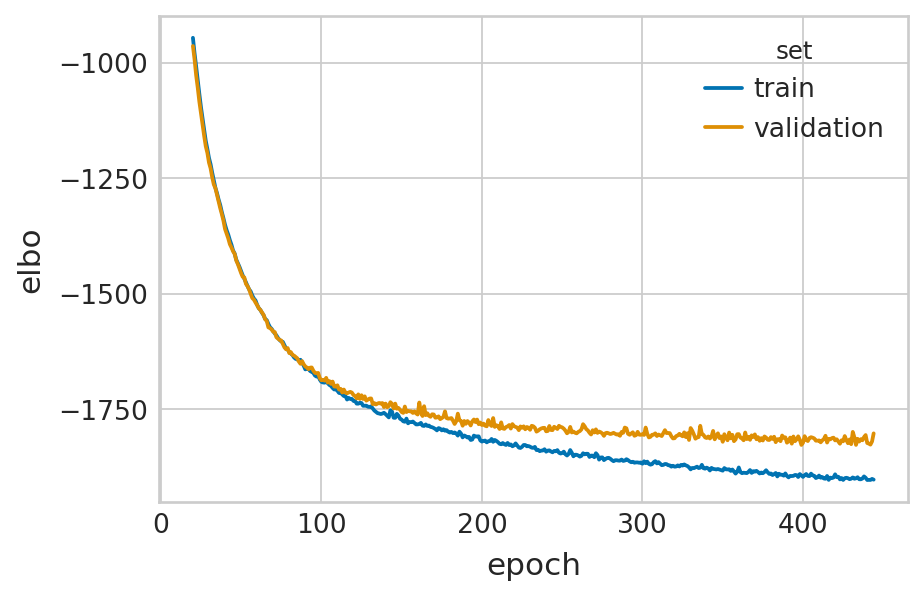

In [10]:
velovi_vaes_const = []
fits_velovi_const = {}
for a, n in zip(adatas, names):
    velovi_vaes_const.append(fit_velovi(a, time_dep_transcription_rate=False))
    fits_velovi_const[n] = get_fit_velovi(a, velovi_vaes_const[-1])

### Time dependent transcription rate

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 479/500:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▊    | 479/500 [05:33<00:14,  1.43it/s, loss=-2.89e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2798.792. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 222/500:  44%|███████████████████████████████████████████▉                                                       | 222/500 [10:28<13:07,  2.83s/it, loss=-4.95e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -4872.801. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 466/500:  93%|████████████████████████████████████████████████████████████████████████████████████████████▎      | 466/500 [02:41<00:11,  2.89it/s, loss=-1.57e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1543.219. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 414/500:  83%|█████████████████████████████████████████████████████████████████████████████████▉                 | 414/500 [03:05<00:38,  2.23it/s, loss=-2.07e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1987.802. Signaling Trainer to stop.


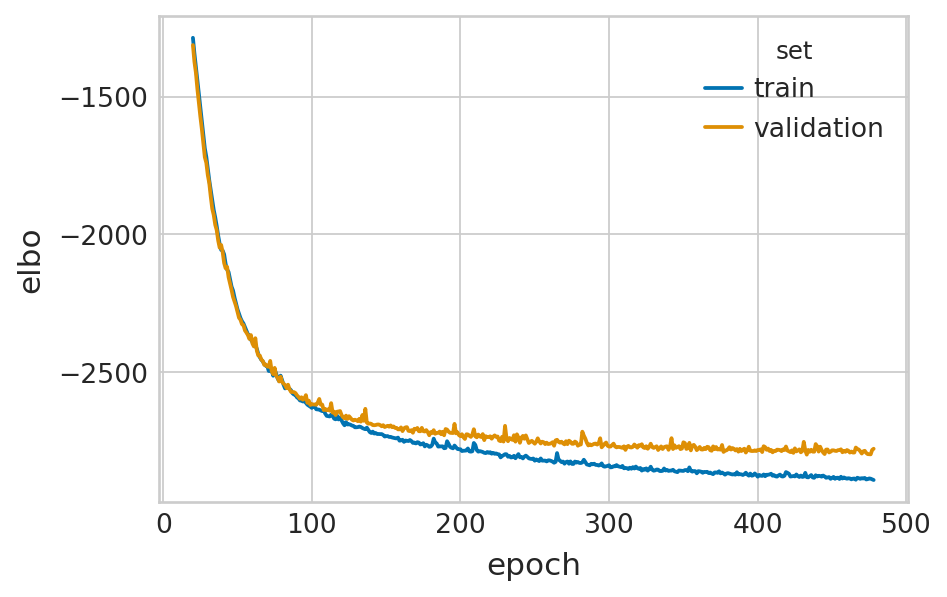

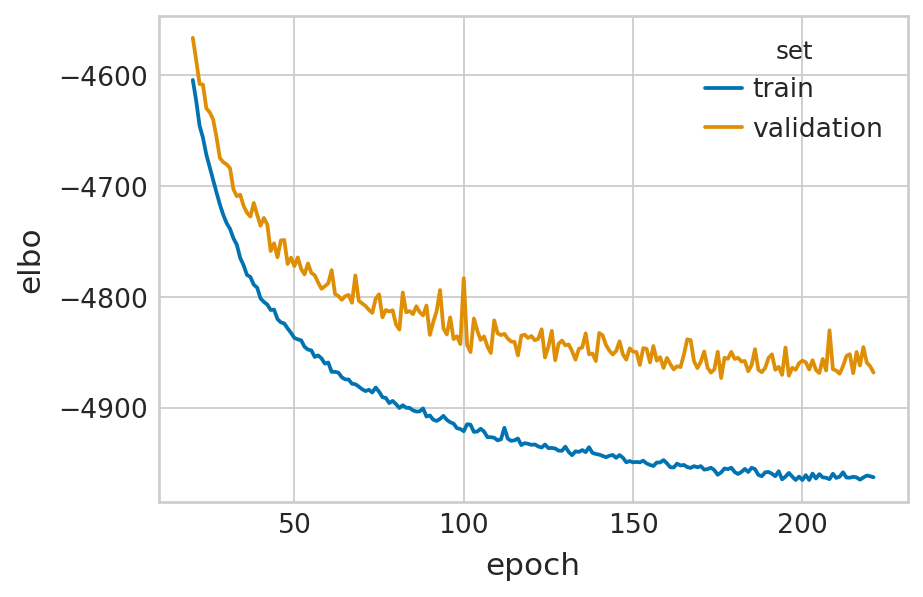

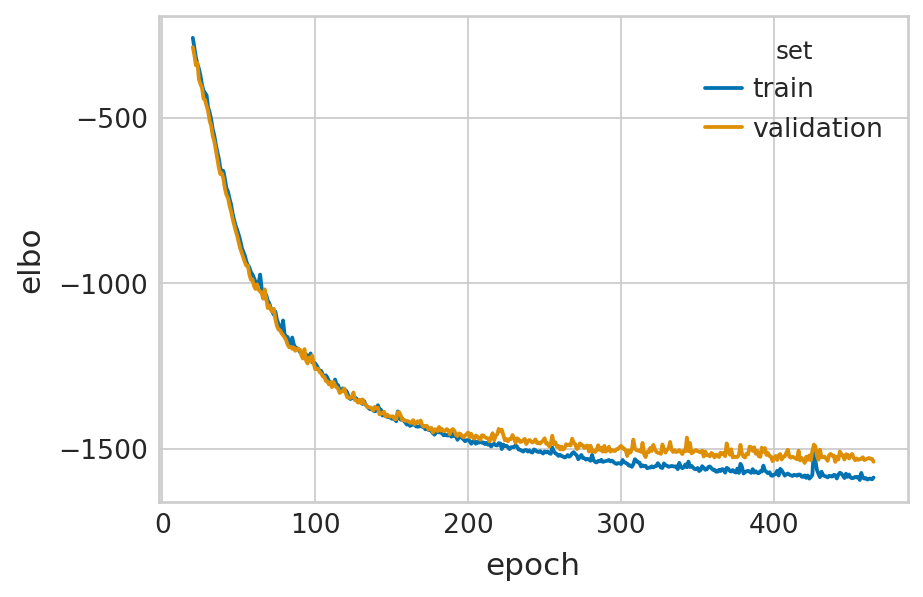

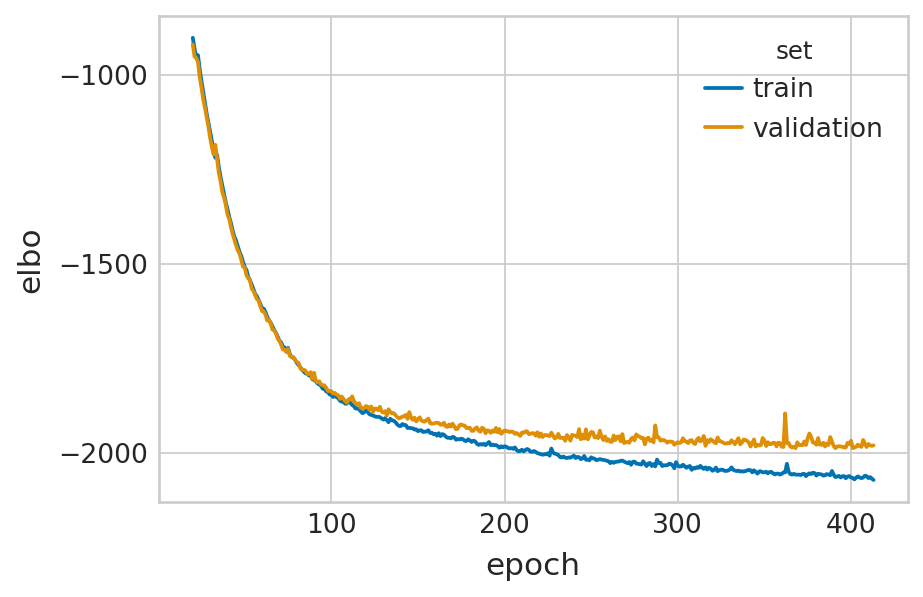

In [11]:
velovi_vaes_time_dep = []
fits_velovi_time_dep = {}
for b, n in zip(bdatas, names):
    velovi_vaes_time_dep.append(fit_velovi(b, time_dep_transcription_rate=True))
    fits_velovi_time_dep[n] = get_fit_velovi(b, velovi_vaes_time_dep[-1])

## MSE

In [12]:
dfs = []
for a, n in zip(adatas, names):
    ms = a.to_df("Ms")
    mu = a.to_df("Mu")
    mse_df = compute_mse(
        ms,
        mu,
        fits_velovi_time_dep[n][0],
        fits_velovi_time_dep[n][1],
        fits_velovi_const[n][0],
        fits_velovi_const[n][1],
    )
    mse_df["Dataset"] = n
    dfs.append(mse_df)
mse_df = pd.concat(dfs, axis=0)

/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


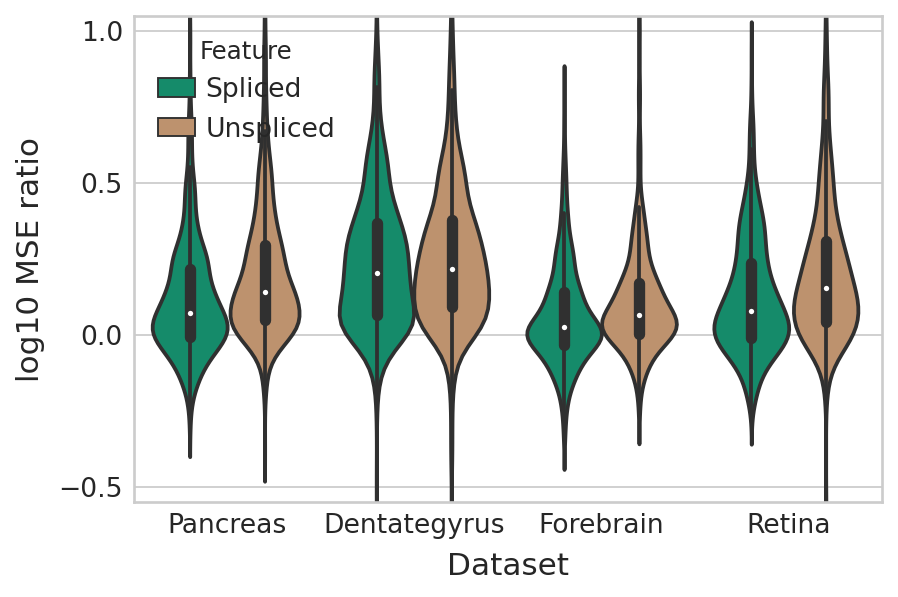

In [25]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(
        data=mse_df,
        orient="v",
        ax=ax,
        x="Dataset",
        y="log10 MSE ratio",
        hue="Feature",
        palette=["#029e73", "#ca9161"],
    );
    ax.set_ylim([-0.55, 1.05]);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'mse_const_vs_time_dep_transcription_rate.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )